<a href="https://colab.research.google.com/github/JaeminKIM-Irene/FC_AI_ML_Project/blob/main/ML_Proejct_Review_AmbrosM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# install necessary libraries

In [3]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# read data
result_list = []
base_url = '/content/drive/MyDrive/Colab Notebooks/data/playground-series-s3e23/'
train = pd.read_csv(base_url+'train.csv', index_col='id')
test = pd.read_csv(base_url+'test.csv', index_col='id')
submission = pd.read_csv(base_url+'sample_submission.csv', index_col='id')
original = pd.read_csv(base_url+'jm1.csv', na_values=['?'])

with pd.option_context('display.min_rows', 6) :
  display(train)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,False
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,False
101762,136.0,18.0,18.0,1.0,296.0,1704.57,0.02,44.82,44.08,77011.02,...,102,1,11,0,22.0,31.0,162.0,135.0,35.0,False


In [16]:
# check missing values and duplicates
train.isna().sum().sum()

train.duplicated().sum()

0

In [17]:
# check imbalance of train data
train.defects.mean()

0.22664426166681406

## [EDA]
#### How much of an EDA can do here?
- **Defects** is the target column, the 21 other columns are the features. All features are numerical.
- There are no missing values.
- There are no duplicates.
- The dataset is somewhat **unbalanced**: Only 23% of the samples belong to the positive class.
  - Will use **StratifiedKFold** for cross-validation.
  - No need upsampling, downsampling.
- The dataset has > 100000 rows. For some algorithms (kernel method / neighborhood components Analysis), this is too much.
- > 100000 rows with 21 features is abundant data. No need to worry much about **overfitting**

This competition doesn't need a fancy EDA. We can learn much more about the data by tuning and cross-validating a few machine learning models.

#### Worth mentioning
1. There are significant differences between the original and synthetic data. Original data is not included in the training.
2. All 21 features are nonnegative and their distribution are right-skewed, resembling an exponential distribution. A **log-transformation** is recommended


## [Difference between original and synthetic data]
**train** and **test** of this competition consist of synthetic data, which was generated based on the real-world dataset **original**. The distribution are not the same.

- P = volume = V = N * log2(mu) (the number of mental comparisons needed to write a program of length N)
- V = volume on minimal implementation = (2 + mu2')log2(2 + mu2')
- L = program length = V*/N
- D = difficulty = 1/L
- L' = 1/D
- I = intelligence = L'*V'
- E = effort to write program = V/L
- T = time to write program = E/18 seconds

Two examples suffice to show that these relationships don't hold for the synthetic data, and the ratio of defects differs between the datsets.

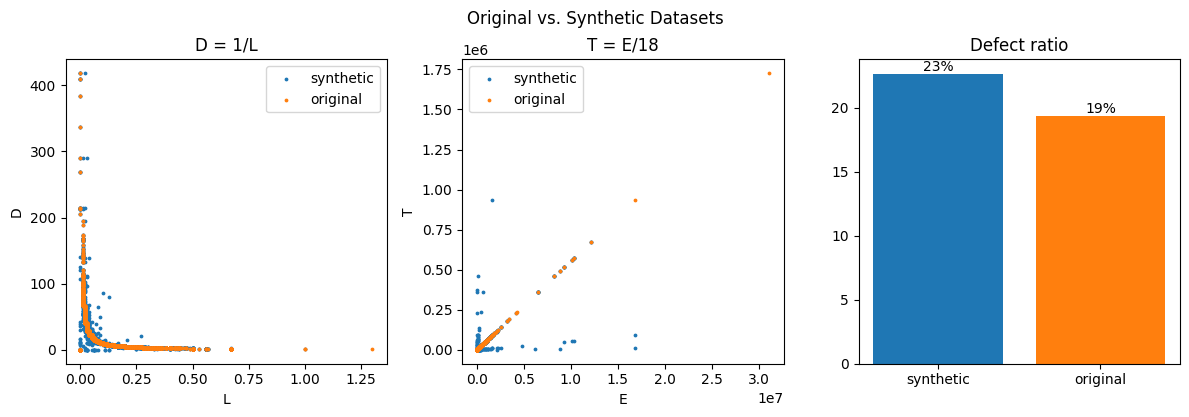

In [23]:
# compare distribution of data between synthetic and original dataset --> do not use original dataset for training models.
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.scatter(train.l, train.d, s=3, label='synthetic')
ax1.scatter(original.l, original.d, s=3, label='original')
ax1.set_xlabel('L')
ax1.set_ylabel('D')
ax1.set_title('D = 1/L')
ax1.legend()

ax2.scatter(train.e, train.t, s=3, label='synthetic')
ax2.scatter(original.e, original.t, s=3, label='original')
ax2.set_xlabel('E')
ax2.set_ylabel('T')
ax2.set_title('T = E/18')
ax2.legend()

bars1 = ax3.bar([0], [train.defects.mean()*100])
bars2 = ax3.bar([1], [original.defects.mean()*100])
ax3.bar_label(bars1, fmt='{:.0f}%')
ax3.bar_label(bars2, fmt='{:.0f}%')
ax3.set_xticks([0, 1], ['synthetic', 'original'])
ax3.set_title('Defect ratio')

plt.tight_layout()
plt.suptitle('Original vs. Synthetic Datasets', y=1.03)
plt.show()

## [A log-transformation is recommended]

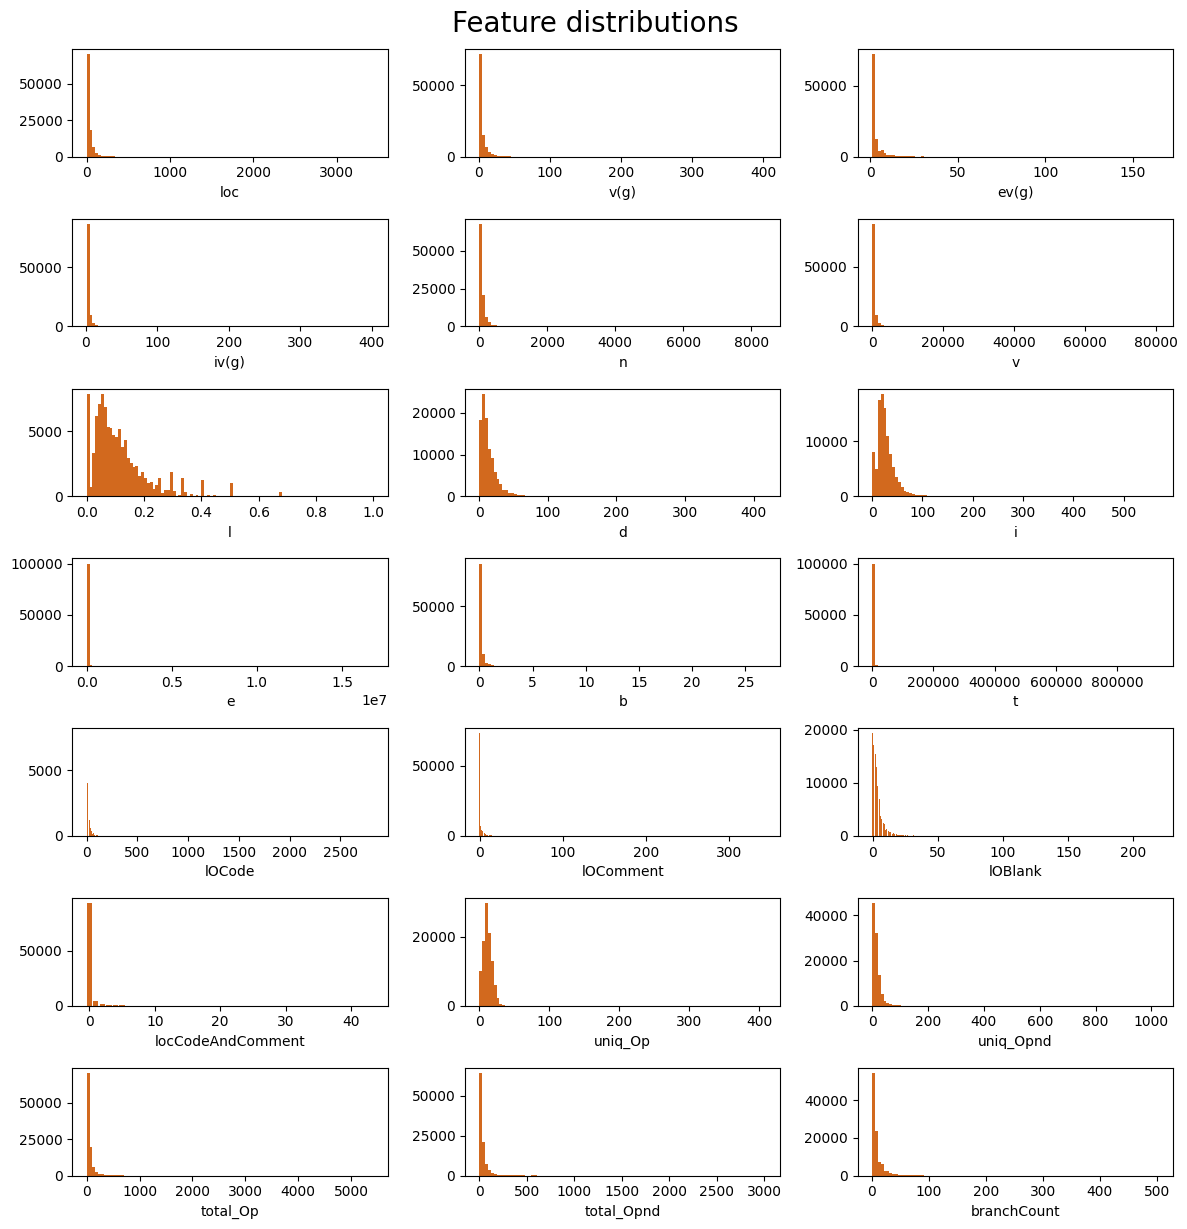

In [25]:
# visualize feature distribution to check right-skewness --> many models profit if we log-transform the data by prepending a FunctionTransformer(np.log1p) to the pipeline
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test.columns, axs.ravel()) :
  if train[col].dtype == float :
    ax.hist(train[col], bins=100, color='chocolate')
  else :  # int
    vc = train[col].value_counts()
    ax.bar(vc.index, vc, color='chocolate')
  ax.set_xlabel(col)

plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

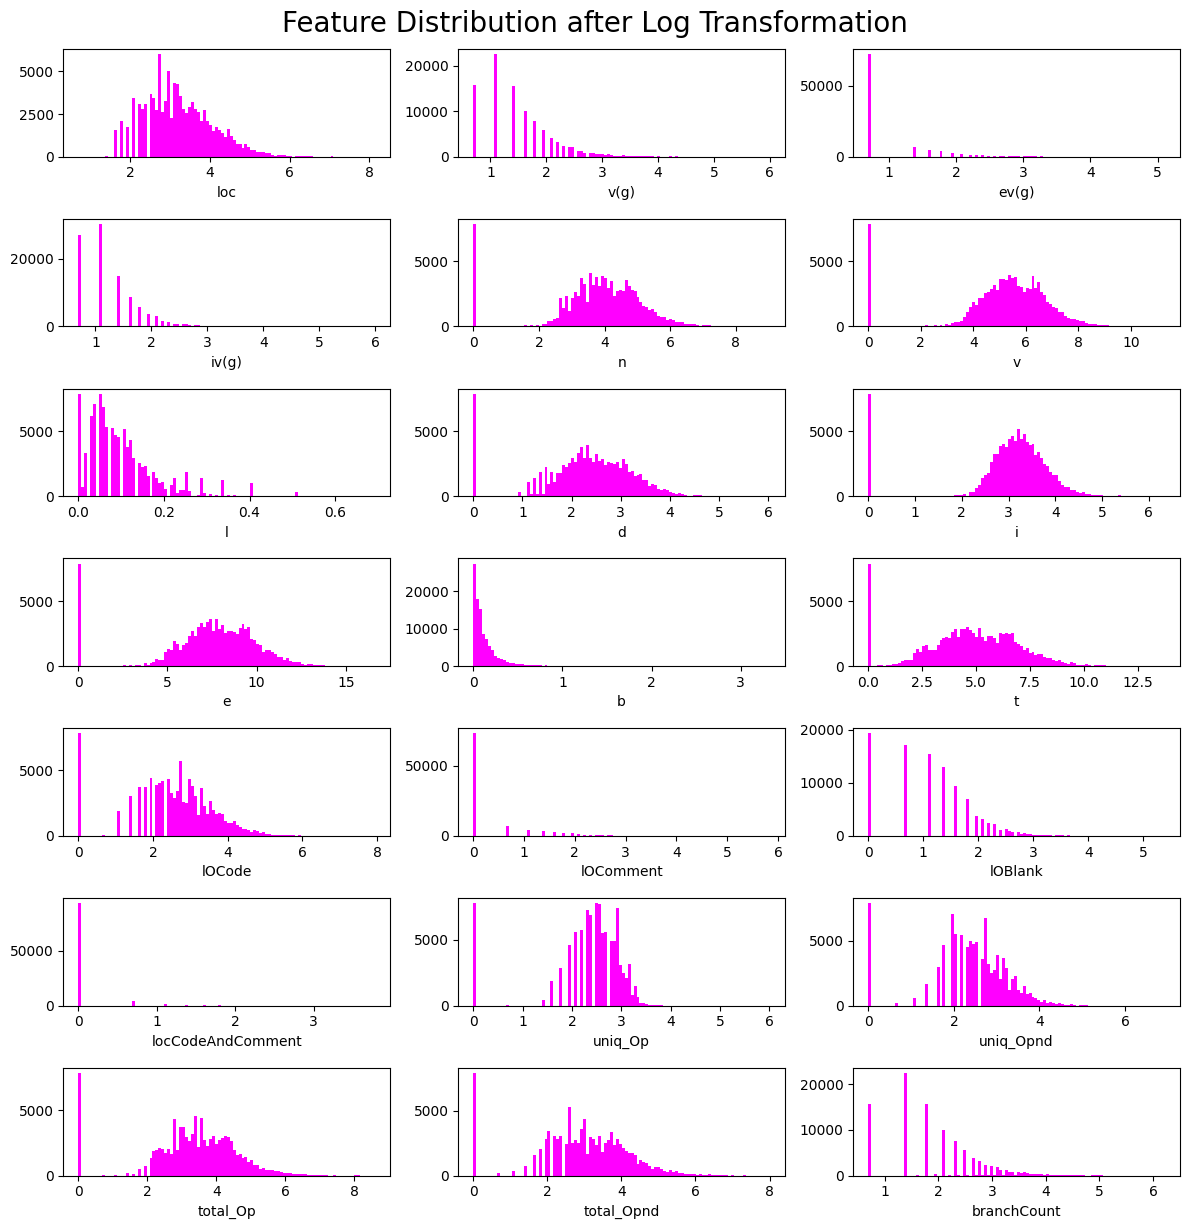

In [26]:
# log-transformed distribution
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test.columns, axs.ravel()) :
  ax.hist(np.log1p(train[col]), bins=100, color='magenta')
  ax.set_xlabel(col)

plt.tight_layout()
plt.suptitle('Feature Distribution after Log Transformation', y=1.02, fontsize=20)
plt.show()

## [Cross Validation]

In [38]:
result_list = []
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def cross_val(model, label) :
  start_time = datetime.now()
  kf = StratifiedKFold(shuffle=True, random_state=61)
  oof = np.full(len(train), np.nan)
  auc_list = []

  for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.defects)) :
    X_tr = train.iloc[idx_tr]
    X_va = train.iloc[idx_va]
    y_tr = X_tr.pop('defects')
    y_va = X_va.pop('defects')
    model.fit(X_tr, y_tr)

    try :
      y_va_pred = model.predict_proba(X_va)[:, 1]
    except AttributeError :
      y_va_pred = model.decision_function(X_va)
    oof[idx_va] = y_va_pred
    auc = roc_auc_score(y_va, y_va_pred)
    auc_list.append(auc)

  auc = np.array(auc_list).mean()
  execution_time = datetime.now() - start_time
  print(f'# AUC {auc:.5f}   time={str(execution_time)[-15:-7]}   {label}')
  result_list.append((auc, label, execution_time))

  return auc

In [39]:
def plot_score_list(label, parameter, xscale='linear') :
  # show scatterplot of the scores in the global variable score_list
  plt.figure(figsize=(6, 3))
  plt.scatter([p for p, s in score_list],
              [s for p, s in score_list])
  plt.xscale(xscale)
  plt.xlabel(f'{parameter}{"  (log-scale)" if xscale=="log" else ""}')
  plt.ylabel('AUC score')
  plt.title(label)
  plt.show()

## [A few models]
### LinearSVC and LogisticRegression
Good to know :
- LinearSVC and LogisticRegression are usually used in a pipline after a StandardScaler
- Linear models are often improved if we add polynomial features. As a dataset has only 21 features, we can afford to add all products of two features by inserting a **PolynomialFeatures** into the pipeline before the StandardScaler. With this addition, the dataset is blown up to 252 features.
- The documentation says for both algorithms : Prefer **dual=False** when n_samples > n_features.
- Regularization is controlled by C (low C = high regularization)
- For logistic regression, **solver='newton_cholesky'** is the fastest solver for the given dataset.
- For our dataset, LogisticRegression gives good score with **class_weight='balanced'**. All predicted probabilities will be too high, but this doesn't hurt the auc score.


# AUC 0.78653   time=0:00:46   Poly-LinearSVC C=0.0001


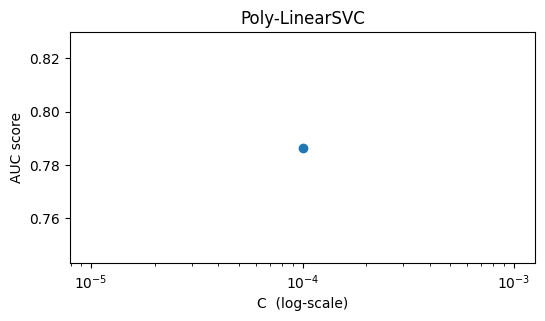

# AUC 0.78806   time=0:01:24   Poly-LinearSVC C=0.001


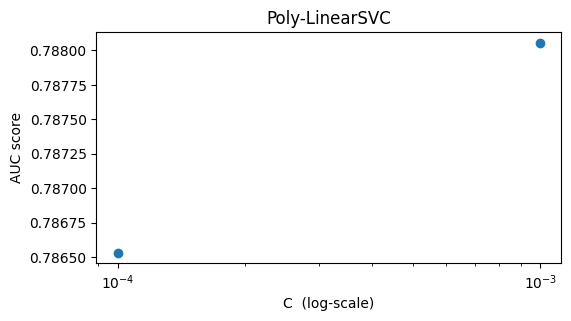

# AUC 0.78858   time=0:02:41   Poly-LinearSVC C=0.01


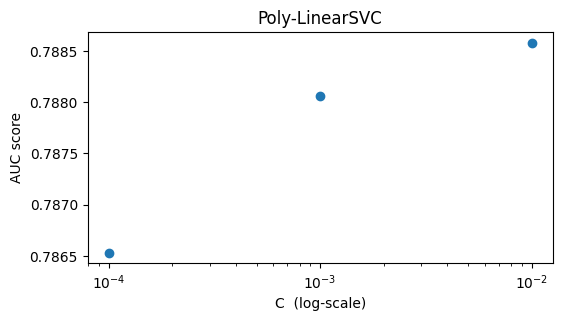

# AUC 0.78823   time=0:05:36   Poly-LinearSVC C=0.1


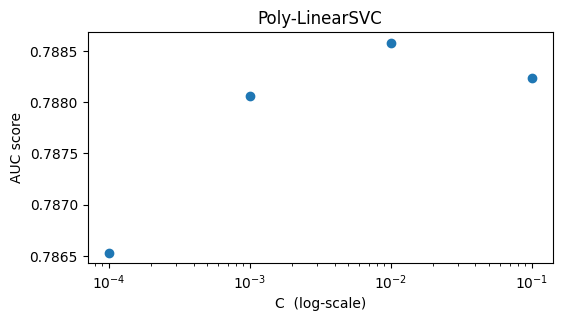

In [40]:
# LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

score_list = []
for C in np.logspace(-4, -1, 4) :
  auc = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                               PolynomialFeatures(2, include_bias=False),
                                StandardScaler(),
                                LinearSVC(dual=False, C=C)),
                  f'Poly-LinearSVC {C=:.2g}')
  score_list.append((C, auc))
  plot_score_list('Poly-LinearSVC', 'C', 'log')

# AUC 0.78903   time=0:00:22   Poly-LogisticRegression C=0.01
# AUC 0.78932   time=0:00:21   Poly-LogisticRegression C=0.024
# AUC 0.78953   time=0:00:20   Poly-LogisticRegression C=0.056
# AUC 0.78964   time=0:00:21   Poly-LogisticRegression C=0.13
# AUC 0.78966   time=0:00:20   Poly-LogisticRegression C=0.32
# AUC 0.78952   time=0:00:24   Poly-LogisticRegression C=0.75
# AUC 0.78933   time=0:00:23   Poly-LogisticRegression C=1.8
# AUC 0.78913   time=0:00:21   Poly-LogisticRegression C=4.2
# AUC 0.78895   time=0:00:20   Poly-LogisticRegression C=10


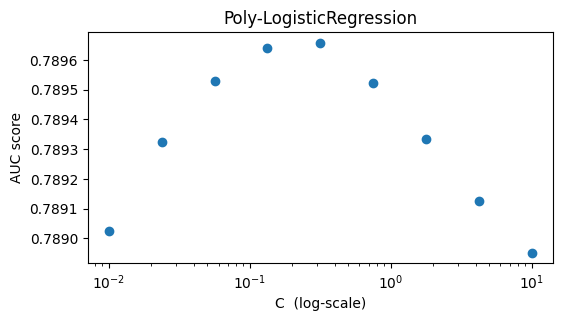

In [41]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

score_list = []
for C in np.logspace(-2, 1, 9) :
  auc = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                PolynomialFeatures(2, include_bias=False),
                                StandardScaler(),
                                LogisticRegression(dual=False, C=C,
                                                   class_weight='balanced',
                                                   max_iter=1500,
                                                   random_state=61,
                                                   solver='newton-cholesky')),
                  f'Poly-LogisticRegression {C=:.2g}')
  score_list.append((C, auc))
plot_score_list('Poly-LogisticRegression', 'C', 'log')

### ExtraTreesClassifier

Good to Know :
- The most important hyperparameter of ExtraTreesClassifier is min_samples_leaf.
  - High min_samples_leaf : Estimator is fast, but underfits
  - Low min_samples_leaf : Estimator is slow and overfits
- Setting max_features to 1.0 usually gives better AUC score than the default of max_features='sqrt', but slows down the training *process*

# AUC 0.78546   time=0:03:15   ET min_samples_leaf=10


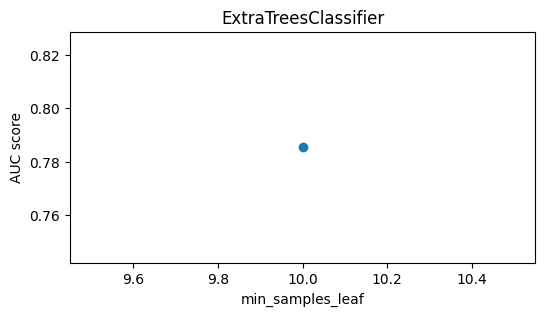

# AUC 0.78864   time=0:03:35   ET min_samples_leaf=20


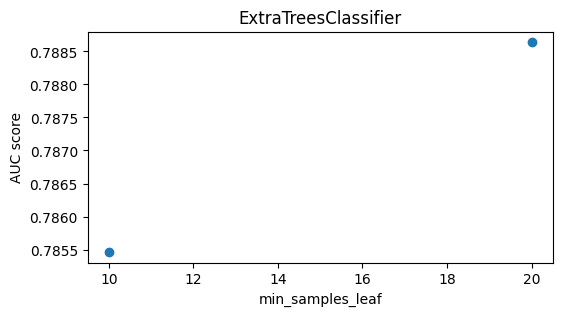

# AUC 0.79069   time=0:03:02   ET min_samples_leaf=50


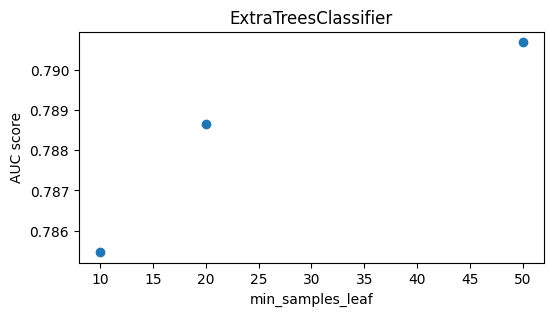

# AUC 0.79101   time=0:02:25   ET min_samples_leaf=100


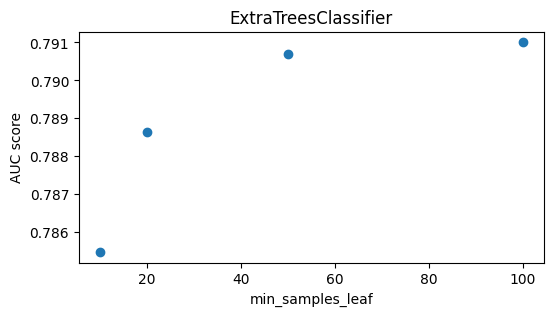

# AUC 0.79081   time=0:01:58   ET min_samples_leaf=150


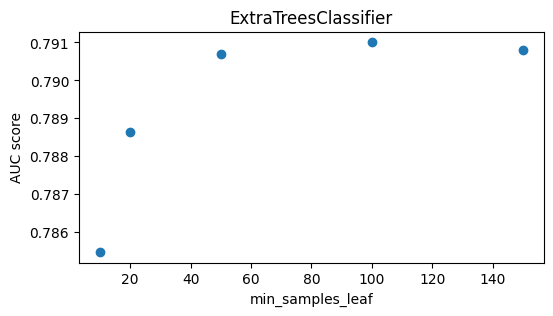

In [42]:
# ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

score_list = []
for min_samples_leaf in [10, 20, 50, 100, 150] :
  auc = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                ExtraTreesClassifier(n_estimators=100,
                                                     min_samples_leaf=min_samples_leaf,
                                                     max_features=1.0,
                                                     random_state=61)),
                  f'ET {min_samples_leaf=}')
  score_list.append((min_samples_leaf, auc))
  plot_score_list('ExtraTreesClassifier', 'min_samples_leaf')

### RandomForestClassifier
Good to know :
- The most important hyperparameter of a random forest is min_samples_leaf.
  - High min_samples_leaf : Estimator is fast, but underfits.
  - Low min_samples_leaf : Estimator is slow, but overfits.
- Setting max_features to 1.0 usually gives better AUC scores than the default of max_features='sqrt', but slow down the training process.

# AUC 0.79080   time=0:05:30   RF min_samples_leaf=100
# AUC 0.79121   time=0:05:02   RF min_samples_leaf=150
# AUC 0.79129   time=0:04:46   RF min_samples_leaf=200
# AUC 0.79110   time=0:04:31   RF min_samples_leaf=250
# AUC 0.79099   time=0:04:16   RF min_samples_leaf=300


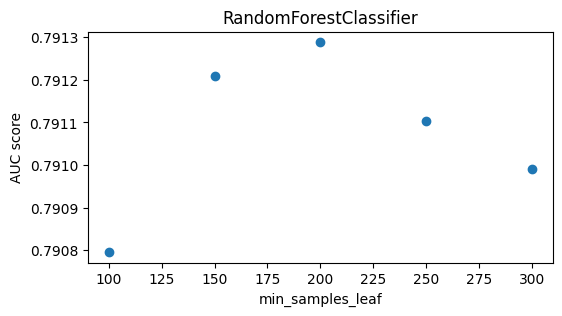

In [43]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

score_list = []
for min_samples_leaf in [100, 150, 200, 250, 300] :
  auc = cross_val(RandomForestClassifier(n_estimators=100,
                                         min_samples_leaf=min_samples_leaf,
                                         max_features=1.0,
                                         random_state=61),
                  f'RF {min_samples_leaf=}')
  score_list.append((min_samples_leaf, auc))
plot_score_list('RandomForestClassifier', 'min_samples_leaf')

### KNeighborsClassifier
Good to know :
- KNeightborsClassifier is usually used in a pipeline after a StandardScaler.
- The most important hyperparameter is n_neighbors

# AUC 0.78662   time=0:01:04   KNN n_neighbors=200
# AUC 0.78730   time=0:01:11   KNN n_neighbors=300
# AUC 0.78747   time=0:01:16   KNN n_neighbors=400
# AUC 0.78735   time=0:01:24   KNN n_neighbors=500
# AUC 0.78727   time=0:01:35   KNN n_neighbors=600
# AUC 0.78715   time=0:01:37   KNN n_neighbors=700


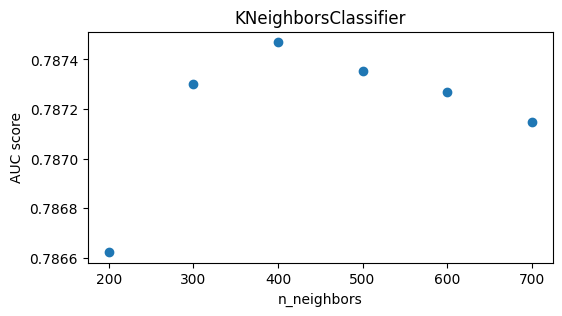

In [44]:
# KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

score_list = []
for n_neighbors in range(200, 800, 100) :
  auc = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                StandardScaler(),
                                KNeighborsClassifier(n_neighbors=n_neighbors,
                                                     weights='distance')),
                  f'KNN {n_neighbors=}')
  score_list.append((n_neighbors, auc))
plot_score_list('KNeighborsClassifier', 'n_neighbors')

### HistGradientBoostingClassifier
Good to know :
- If the sample size is larger than 10000, HistGradientBoostingClassifier uses 10% of its training data as an internal validation set for early stopping. This means that we don't need to tune **max_iter**.

In [45]:
from sklearn.ensemble import HistGradientBoostingClassifier

auc = cross_val(HistGradientBoostingClassifier(random_state=61),
                f'HistGradientBoostingClassifier')

# AUC 0.79130   time=0:00:09   HistGradientBoostingClassifier


## [Ensemble]
Ensemble three models with kernel approximation :
- HistGradientBoostingClassifier
- RandomForestClassifier
- Logistic Regression

In [46]:
from sklearn.ensemble import VotingClassifier
from sklearn.kernel_approximation import Nystroem

ensemble = VotingClassifier(
    [('hgb', HistGradientBoostingClassifier(random_state=61)),
     ('rf', RandomForestClassifier(min_samples_leaf=200,
                                   max_features=1.0,
                                   random_state=61)),
     ('ny', make_pipeline(FunctionTransformer(np.log1p),
                          Nystroem(n_components=400, random_state=61),
                          StandardScaler(),
                          LogisticRegression(dual=False, C=0.0032,
                                             max_iter=1500,
                                             random_state=61)))],
    voting='soft',
    weights=[0.5, 0.3, 0.2])
auc = cross_val(ensemble, 'Ensemble(HGB+RF_NY)')

# AUC 0.79236   time=0:06:28   Ensemble(HGB+RF_NY)


In [49]:
ensemble.fit(train.iloc[:, :-1], train.defects)
y_pred = ensemble.predict_proba(test)[:, 1]
submission = pd.Series(y_pred, index=test.index, name='defects')
submission.to_csv('submission.csv')